In [1]:
import diffprivlib as dp
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
np.random.seed(31415)
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import math
import fairlearn.metrics as mf

In [2]:
def get_classifier(cls_str, diffpriv=True, bounds=None, epsilon=None, acc=None):
    '''

    :param cls_str: one of ['NB', 'LR', 'RF']
    :param diffpriv:Whether dp classifier or regular classifier
    :param bounds:  Bounds of the data, provided as a tuple of the form (min, max).
                    min and max can either be scalars, covering the min/max of the
                    entire data, or vectors with one entry per feature. If not
                    provided, the bounds are computed on the data when .fit() is
                    first called, resulting in a PrivacyLeakWarning
    :param epsilon: Privacy parameter for the model. default: 1.0
    :param acc:     Accountant to keep track of privacy budget
    :return:        The classifier instantiated
    '''

    if(cls_str == 'NB' and diffpriv == True):
        return dp.models.GaussianNB(epsilon=epsilon, bounds=bounds, accountant=acc)
    
    elif(cls_str == 'NB' and diffpriv == False):
        return GaussianNB()
    
    elif(cls_str == 'LR' and diffpriv == True):
        return dp.models.LogisticRegression(epsilon=epsilon, bounds=bounds, accountant=acc)
    
    elif(cls_str == 'LR' and diffpriv == False):
        return LogisticRegression(random_state=0)
    
    elif(cls_str == 'RF' and diffpriv == True):
        return dp.models.RandomForestClassifier(epsilon=epsilon, bounds=bounds, accountant=acc)
    
    elif(cls_str == 'RF' and diffpriv == False):
        return RandomForestClassifier(random_state=0)
    
    else:
        print("Incorrect Classifier - must be one of ['NB', 'LR', 'RF']")
        return

# Load Data

In [8]:
save_data_loc = '../data/fm2020/'
X_train = pd.read_pickle(save_data_loc+'X_train.gz')
y_train = pd.read_pickle(save_data_loc+'y_train.gz')
X_test = pd.read_pickle(save_data_loc+'X_test.gz')
y_test = pd.read_pickle(save_data_loc+'y_test.gz')

# Model Training and Plotting Curves

In [26]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value        
    return smoothed

def plot_params(X_train, y_train, X_test, y_test, num_trials, cls_str, gender_attr_str, race_attr_str):
    
    eps_list = [1e-2, 1e-1, 1e0, 1e1] # np.logspace(-2, 2, 10)
    acc_list = []
    dem_parity_list_gender = []
    dem_parity_list_race = []
    eq_opp_list_gender = []
    eq_opp_list_race = []
    acc_score = np.zeros((num_trials, len(eps_list)))
    dem_parity_score_gender = np.zeros((num_trials, len(eps_list)))
    dem_parity_score_race = np.zeros((num_trials, len(eps_list)))
    eq_opp_score_gender = np.zeros((num_trials, len(eps_list)))
    eq_opp_score_race = np.zeros((num_trials, len(eps_list)))

    for i in tqdm(range(num_trials)):    
        for j,eps in enumerate(eps_list):
#             print('running for trial {}, eps {}...'.format(i,eps))
            clf = get_classifier(cls_str, diffpriv=True, epsilon=eps)
            clf.fit(X_train,y_train)
            y_pred = clf.predict(X_train)            
            acc_score[i,j] = clf.score(X_test, y_test)
            # fairness metrics need the sensitive column to be binary {0,1}. Cannot normalize!            
            dem_parity_score_gender[i,j] = mf.demographic_parity_ratio(y_true=y_train, y_pred=y_pred, sensitive_features=X_train[gender_attr_str])
            dem_parity_score_race[i,j] = mf.demographic_parity_ratio(y_true=y_train, y_pred=y_pred, sensitive_features=X_train[race_attr_str])
            eq_opp_score_gender[i,j] = mf.equalized_odds_ratio(y_true=y_train, y_pred=y_pred, sensitive_features=X_train[gender_attr_str])
            eq_opp_score_race[i,j] = mf.equalized_odds_ratio(y_true=y_train, y_pred=y_pred, sensitive_features=X_train[race_attr_str])

    print(acc_score)
    clf = get_classifier(cls_str, diffpriv=False)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_train)    
    acc = clf.score(X_test, y_test)    
    dp_g = mf.demographic_parity_ratio(y_true=y_train, y_pred=y_pred, sensitive_features=X_train[gender_attr_str])
    dp_r = mf.demographic_parity_ratio(y_true=y_train, y_pred=y_pred, sensitive_features=X_train[race_attr_str])
    eo_g = mf.equalized_odds_ratio(y_true=y_train, y_pred=y_pred, sensitive_features=X_train[gender_attr_str])
    eo_r = mf.equalized_odds_ratio(y_true=y_train, y_pred=y_pred, sensitive_features=X_train[race_attr_str])
    
    acc_list = np.mean(acc_score, axis=0)        
    dem_parity_list_gender = pd.Series(np.mean(dem_parity_score_gender, axis=0)).interpolate().fillna(method='bfill')
    dem_parity_list_race = pd.Series(np.mean(dem_parity_score_race, axis=0)).interpolate().fillna(method='bfill')
    eq_opp_list_gender = pd.Series(np.mean(eq_opp_score_gender, axis=0)).interpolate().fillna(method='bfill')
    eq_opp_list_race = pd.Series(np.mean(eq_opp_score_race, axis=0)).interpolate().fillna(method='bfill')
    
    plt.suptitle(cls_str + ' Classifier Accuracy and Fairness Metrics vs Epsilon') 
    plt.title('Dashed and Solid Lines for Standard and Private Classifiers', fontsize='small')
    plt.axhline(acc, color='r', linestyle='--')
    plt.axhline(dp_g, color='g', linestyle='--')
    plt.axhline(dp_r, color='b', linestyle='--')
    plt.axhline(eo_g, color='m', linestyle='--')
    plt.axhline(eo_r, color='y', linestyle='--')   
    
    plt.semilogx(eps_list, smooth(acc_list,0.6), label='Accuracy', color='r')
    plt.semilogx(eps_list, smooth(dem_parity_list_gender,0.6), label='Dem Par Gender', color='g')
    plt.semilogx(eps_list, smooth(dem_parity_list_race,0.6), label='Dem Par Race', color='b')
    plt.semilogx(eps_list, smooth(eq_opp_list_gender,0.6), label='Eq Opp Gender', color='m')
    plt.semilogx(eps_list, smooth(eq_opp_list_race,0.6), label='Eq Opp Race', color='y')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylim(0,1)
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy / Fairness')
    
    plt.savefig('plots/'+cls_str+'.png', dpi=150, bbox_inches='tight')
    plt.show()    

100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


[[0.5 0.4 0.5 0.6]
 [0.5 0.5 0.5 0.3]
 [0.8 0.6 0.7 0.6]
 [0.8 0.5 0.5 0.5]
 [0.4 0.6 0.5 0.5]]


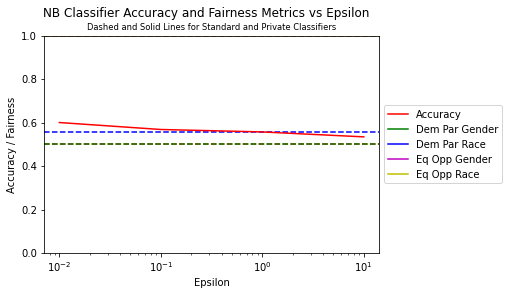

In [27]:
plot_params(X_train[:10], y_train[:10], X_test[:10], y_test[:10], 5, 'NB', 'gender_m', 'r_white_non_hisp')

100%|███████████████████████████████████████████| 25/25 [10:02<00:00, 24.11s/it]


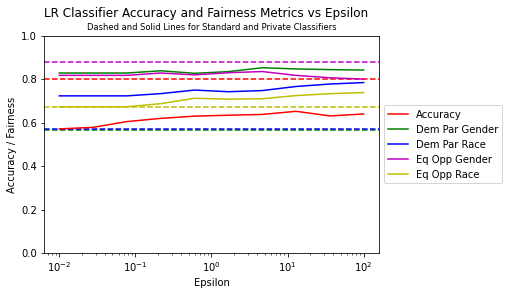

In [10]:
plot_params(X_train, y_train, X_test, y_test, 25, 'LR', 'Sex', 'Race')

In [11]:
# plot_params(X_train, y_train, X_test, y_test, 50, 'RF')
# bug in IBM diffprivlib RandomForestClassifier implementation of Score. Skipping for now.